In [1]:
# David Cabezas
# Estudio de la relevancia de las variables por sus apariciones en Random Forest

In [2]:
SEED=312

In [3]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

import graphviz

from collections import Counter

In [4]:
DATA='data/mamografias.csv'

# Función para leer los datos
def readData(data_file):
    return pd.read_csv(data_file,sep=',', na_values='?')

data = readData(DATA) # Lectura de los datos

data.rename(columns = {'BI-RADS':'BiRads'}, inplace = True) # Para poder referirnos a esta columna como data.BiRads
data.BiRads.replace(0,pd.NA,inplace=True) # BiRads 0 significa radiografía insuficiente
data.Shape.replace('N',pd.NA,inplace=True) # Lo mismo pasa con Shape N
data.replace(pd.NA, np.nan, inplace=True)

data=data.dropna() # Eliminamos las instancias con valores perdidos
data.shape[0] # Nos quedamos con 825 instancias

le = preprocessing.LabelEncoder()
data.Shape = le.fit_transform(data.Shape)
data.Severity = le.fit_transform(data.Severity)

dataArray=np.array(data)

x=dataArray[:,:-1]
y=dataArray[:,-1]

features=['BI-RADS', 'Age', 'Shape', 'Margin', 'Density']
data

,BiRads,Age,Shape,Margin,Density,Severity
0,5.0,67.0,1,5.0,3.0,1
2,5.0,58.0,0,5.0,3.0,1
3,4.0,28.0,3,1.0,3.0,0
8,5.0,57.0,3,5.0,3.0,1
10,5.0,76.0,3,4.0,3.0,1
...,...,...,...,...,...,...
956,4.0,47.0,2,1.0,3.0,0
957,4.0,56.0,0,5.0,3.0,1
958,4.0,64.0,0,5.0,3.0,0
959,5.0,66.0,0,5.0,3.0,1


In [5]:
# Leo Breiman, Adele Cutler: 66% samples
# Hay que reducir la complejidad de alguna forma, si no todas las variables aparecerían
rf=RandomForestClassifier(max_samples=0.667,ccp_alpha=0.01,random_state=SEED) # tb se puede limitar la complejidad con max_depth
rf.fit(x,y)
forest=rf.estimators_ # Estimadores simples

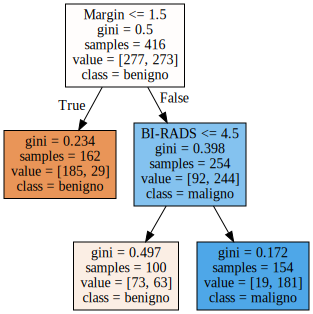

In [6]:
t=forest[np.random.randint(0,len(forest))] # Podemos visualizar los estimadores
dot_data = tree.export_graphviz(t, out_file=None, 
                                feature_names=features,  
                                class_names=['benigno', 'maligno'],
                                filled=True)

# Save and draw graph
graph = graphviz.Source(dot_data,format="png")
graph

In [7]:
feature_count=dict(zip(features,[0]*len(features)))
feature_count

{'Age': 0, 'BI-RADS': 0, 'Density': 0, 'Margin': 0, 'Shape': 0}

In [8]:
for t in forest:
    c=Counter(t.tree_.feature)
    for i in range(len(features)):
        feature_count[features[i]]+=(1 if c[i]>0 else 0)

In [9]:
feature_count # Apariciones de cada variable

{'Age': 70, 'BI-RADS': 98, 'Density': 13, 'Margin': 64, 'Shape': 67}

In [10]:
[(caracteristica,apariciones/100) for caracteristica, apariciones in feature_count.items()]

[('BI-RADS', 0.98),
 ('Age', 0.7),
 ('Shape', 0.67),
 ('Margin', 0.64),
 ('Density', 0.13)]

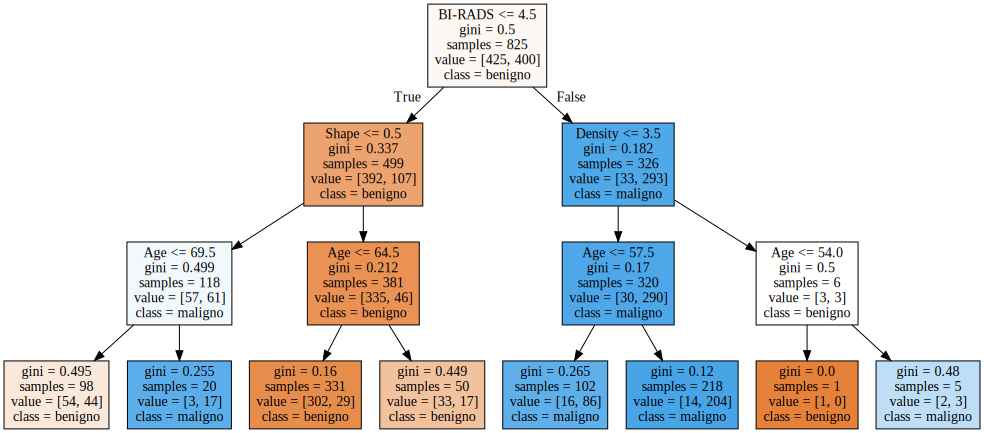

In [16]:
# Comparación con Árbol de Decisión

dt=tree.DecisionTreeClassifier(ccp_alpha=0.005, random_state=SEED) # Usa Shape y Age
#dt=tree.DecisionTreeClassifier(max_depth=3, random_state=SEED) # Mete density arriba, y es muy mala

dt.fit(x,y)

# DOT data
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=features,  
                                class_names=['benigno', 'maligno'],
                                filled=True)

# Save and draw graph
graph = graphviz.Source(dot_data,format="png")
#graph.render(filename='figures/tree_cpp')
#graph.render(filename='figures/tree_depth')
graph

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn=KNeighborsClassifier()

np.mean(cross_val_score(knn,x,y))

0.7951515151515152

In [13]:
data2=data.drop('Density',axis='columns') # Eliminamos una variable y mejora la Accuracy
dataArray2=np.array(data2)

x2=dataArray2[:,:-1]
y2=dataArray2[:,-1]

np.mean(cross_val_score(knn,x2,y2))

0.8036363636363637

In [14]:
data3=data2.drop('Margin',axis='columns') # Margin es la siguiente variable menos relevante, pero su presencia es muy alta
dataArray3=np.array(data3)

x3=dataArray3[:,:-1]
y3=dataArray3[:,-1]

np.mean(cross_val_score(knn,x3,y3))

0.7927272727272727

In [15]:
Counter(data.Density) # La distribución de Density es prácticamente degenerada

Counter({1.0: 11, 2.0: 56, 3.0: 750, 4.0: 8})